In [1]:
%reset -f

import warnings
warnings.filterwarnings('ignore')

import os
os.chdir('D:\Kaggle\Kaggle - forest cover')

import pandas as pd
import numpy as np
import matplotlib as mpl
from IPython import display
import seaborn as sns

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

np.random.seed(123)

In [2]:
# import training set
train = pd.read_csv('train.csv')

# import test set
test  = pd.read_csv('test.csv')

In [3]:
# view dimensions of training set
print(train.shape)

# view dimensions of test set
print(test.shape)

# extract target variable from training set
target = train['Cover_Type']
del train['Cover_Type']

# extract Id from test set (for submission file later), then remove Id from training and test sets
test_id = test['Id']
del test['Id'], train['Id']

# concatenate the rows of training and test sets
full = pd.concat([train,test], axis='rows')

(15120, 56)
(565892, 55)


In [4]:
# check the data type of each variable
print(full.dtypes) # all integers

Elevation                             int64
Aspect                                int64
Slope                                 int64
Horizontal_Distance_To_Hydrology      int64
Vertical_Distance_To_Hydrology        int64
Horizontal_Distance_To_Roadways       int64
Hillshade_9am                         int64
Hillshade_Noon                        int64
Hillshade_3pm                         int64
Horizontal_Distance_To_Fire_Points    int64
Wilderness_Area1                      int64
Wilderness_Area2                      int64
Wilderness_Area3                      int64
Wilderness_Area4                      int64
Soil_Type1                            int64
Soil_Type2                            int64
Soil_Type3                            int64
Soil_Type4                            int64
Soil_Type5                            int64
Soil_Type6                            int64
Soil_Type7                            int64
Soil_Type8                            int64
Soil_Type9                      

In [5]:
# check for obvious data entry errors
for i in range(0,51,10):
    print(full.ix[:,i:i+10].describe()) # no obvious data entry errors

           Elevation         Aspect          Slope  \
count  581012.000000  581012.000000  581012.000000   
mean     2959.365301     155.656807      14.103704   
std       279.984734     111.913721       7.488242   
min      1859.000000       0.000000       0.000000   
25%      2809.000000      58.000000       9.000000   
50%      2996.000000     127.000000      13.000000   
75%      3163.000000     260.000000      18.000000   
max      3858.000000     360.000000      66.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                     581012.000000                   581012.000000   
mean                         269.428217                       46.418855   
std                          212.549356                       58.295232   
min                            0.000000                     -173.000000   
25%                          108.000000                        7.000000   
50%                          218.000000                       3

In [6]:
# view the class frequencies of the target variable
print(target.value_counts()) # classes are balanced

7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: Cover_Type, dtype: int64


In [7]:
# check for missing values
print(full.isnull().any().describe()) # no missing values among the features
print('-'*50)
print(target.isnull().any()) # no missing values in the target variable

count        54
unique        1
top       False
freq         54
dtype: object
--------------------------------------------------
False


In [8]:
# create a variable that reflects the diagonal distance to hydrology
full['diagonal_distance_to_hydrology'] = np.sqrt(full['Horizontal_Distance_To_Hydrology']**2 + full['Vertical_Distance_To_Hydrology']**2)

# create a variable that reflects the mean horizontal distance from various amenities
full['mean_horizontal_distance'] = full[['Horizontal_Distance_To_Hydrology','Horizontal_Distance_To_Fire_Points','Horizontal_Distance_To_Roadways']].mean(axis=1)

# create a variable that reflects the mean hillshade
full['mean_hillshade'] = full[['Hillshade_9am','Hillshade_Noon','Hillshade_3pm']].mean(axis=1)

In [9]:
# split the full dataset into train and test sets
train = full[:train.shape[0]]
test = full[train.shape[0]:]

the mean training accuracy is: 1.0
the mean validation accuracy is: 0.7866402116402116


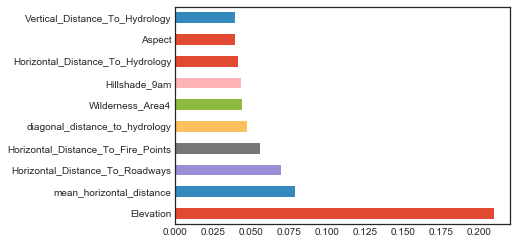

In [10]:
# first model: random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection

# initialize a template for random forest, based on the parameters you want to set
rfc = RandomForestClassifier(n_jobs = -1, # fully utilize the cores on your computer
                             n_estimators = 200, # number of trees
                             max_features = "sqrt", # number of features to consider at each split
                             max_depth = train.shape[0]) # maximum tree depth

# perform cross-validation
rfc_cv = model_selection.cross_validate(rfc,
                                        train,
                                        target,
                                        scoring = 'accuracy',
                                        cv = 10)

print("the mean training accuracy is:", rfc_cv['train_score'].mean())
print("the mean validation accuracy is:", rfc_cv['test_score'].mean())

# fit the random forest
rfc_fitted = rfc.fit(train,target)

# plot feature importance (as determined by the built random forest model)
feature_importances = pd.Series(rfc_fitted.feature_importances_, index=train.columns)
feature_importances = feature_importances.sort_values(ascending=False) # sort from highest to lowest importance
feature_importances.nlargest(10).plot(kind='barh') # seems like elevation is by far the most useful predictor

In [11]:
# second model: artificial neural network
from sklearn.neural_network import MLPClassifier

# scale the features before feeding them into neural network
from sklearn.preprocessing import StandardScaler

scaled_train = StandardScaler().fit_transform(train)
scaled_train = pd.DataFrame(scaled_train, columns=train.columns)

scaled_test = StandardScaler().fit_transform(test)
scaled_test = pd.DataFrame(scaled_test, columns=test.columns)

# initialize a template for neural network, based on the parameters you want to set
ann = MLPClassifier(hidden_layer_sizes = (int(scaled_train.shape[1]/2)), # number of neurons in the hidden layer(s)
                    max_iter = 300) # max number of epochs

# perform cross-validation
ann_cv = model_selection.cross_validate(ann,
                                        scaled_train,
                                        target,
                                        scoring = 'accuracy',
                                        cv = 10)

print("the mean training accuracy is:", ann_cv['train_score'].mean())
print("the mean validation accuracy is:", ann_cv['test_score'].mean())

# fit the neural network
ann_fitted = ann.fit(scaled_train,target)

the mean training accuracy is: 0.8006687242798354
the mean validation accuracy is: 0.6951719576719577


C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

the mean training accuracy is: 0.7877351557907113
the mean validation accuracy is: 0.7018518518518518


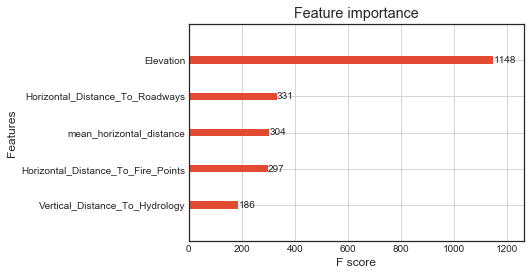

In [12]:
# third model: xgboost
from xgboost import XGBClassifier

# initialize a template for xgboost, based on the parameters you want to set
xgb = XGBClassifier(objective = 'multi:softmax',
                    learning_rate = 0.1,
                    max_depth = 3,
                    n_estimators = 100,
                    silent = True,
                    n_jobs = -1)

# perform cross-validation
xgb_cv = model_selection.cross_validate(xgb,
                                        train,
                                        target,
                                        scoring = 'accuracy',
                                        cv = 10)

print("the mean training accuracy is:", xgb_cv['train_score'].mean())
print("the mean validation accuracy is:", xgb_cv['test_score'].mean())

# fit the xgboost model
xgb_fitted = xgb.fit(train,target)

# plot feature importance (as determined by the built xgboost model)
from xgboost import plot_importance
plot_importance(xgb_fitted,
                max_num_features = 5) # show the top 5 most important features

In [13]:
# seems like random forest is the best model; use it to make predictions
predictions_rfc = rfc_fitted.predict(test)
predictions_rfc = predictions_rfc.astype('int')

submission_rfc = pd.DataFrame({'Id': test_id,
                               'Cover_Type': predictions_rfc})
submission_rfc.to_csv("sample_submission.csv", index=False)